# Trope Association Study

## Aim:
In this notebook, a graph of tropes will be generated from the pickled dictionary **film_trope_dict**, and be used to suggest commonly associated tropes based on user-submitted trope list. Weighted edges will be calulated between tropes that appeared in the same movie. 

Since the resulting graph is quite large (definitely too large for a web app), this graph might need to be translated back to a nested dictionary: 

*{trope_A: {related_trope1:weight1, related_trope2:weight2,...}}*

**Note:** this trope dataset is not joined with the omdb dataset for the purpose of producing the graph, in order to fully use all available DBTropes data.

## Steps:
1. [X] Prior to making the graph, plot the frequency histogram of all tropes. Consider cutting its long tail.
2. [X] Make the graph.
25. [X] Translate to a new dictionary, and pickle it. 
3. [.] Recommendation engine.
4. [.] Filtering user input & handling errors. 
45. [ ] Consider only output tropes that do not have top frequncies, aka not 'staple stropes' such as ShoutOut.
5. [ ] Bonus: Auto-complete available trope names as user is typing (only in web app?).
6. [ ] Bonus: Movie lookup from a list of tropes: does any movie use all these tropes?
7. [ ] Bonus: Convert the data structure for lookups from dictionaries to Redis or postgres

## ! Possible Starting Points!
1. **film_trope_dict_python2.pkl**, aka. starting from the top
2. **trope_graph.pkl**, the graph of tropes (tropes with counts <= 4 already filtered out)
3. **trope_assn_dict.pkl**, the dictionary of {trope: neighbor trope info}

# Imports

In [14]:
# Put all imports in this cell

# Basic needs
from __future__ import print_function  # Because some of the code was moved from Python 3 to 2
import pickle
import re
import itertools
import collections

# For graphs
import networkx as nx
import heapq

# PyData stuff
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Perculiar packages
# unidecode: for converting weird unicode characters to ascii, eg. Nausicaä to Nausicaa
# without unidecode Nausicaä will be converted to Nausica, not Nausicaa
import unidecode 

In [2]:
# read pickled python dict
pkl_file = open('film_trope_dict_python2.pkl', 'rb')
film_trope_dict = pickle.load(pkl_file)
pkl_file.close()

In [3]:
# Same foundation df as in other notebooks of this project.
def read_dict_to_df(input_dict):
    '''Take a dict of {title : [list of tropes in this title], 
       return a DataFrame of all film-trope pairs with an arbituary index.
       Each row of the DataFrame: autoincremented index, name of title, name of trope.'''
    df = pd.DataFrame.from_dict(input_dict, orient ="index").sort_index().stack().reset_index(level=1, drop=True).reset_index()    
    df.columns = ['title', 'trope']
    return df

# This database is the foundation of all analysis.
film_trope_df = read_dict_to_df(film_trope_dict)
film_trope_df.head()

,title,trope
0,ABeautifulMind,ScienceRelatedMemeticDisorder
1,ABeautifulMind,HollywoodNerd
2,ABeautifulMind,TheBigBoard
3,ABeautifulMind,MadMathematician
4,ABeautifulMind,EEqualsMCHammer


In [4]:
trope_count_df = film_trope_df.groupby(['trope']).count().reset_index()
trope_count_df.columns=['trope', 'count']

In [5]:
print('Total # of tropes', len(trope_count_df))
trope_count_df.head()

Total # of tropes 18270


,trope,count
0,ABNegative,6
1,ABirthdayNotABreak,3
2,ABloodyMess,3
3,ABoyAGirlAndABabyFamily,2
4,ABoyAndHisX,42


In [6]:
trope_count_df['count'].describe()

count    18270.000000
mean        14.085878
std         38.272623
min          1.000000
25%          2.000000
50%          5.000000
75%         12.000000
max       1502.000000
Name: count, dtype: float64

In [7]:
for i in range(1, 6):
    frac = len(trope_count_df[trope_count_df['count'] <= i]) * 1.0 / len(trope_count_df)
    print('Fraction of tropes having <= {} counts: {}'.format(i, frac))

Fraction of tropes having <= 1 counts: 0.183032293377
Fraction of tropes having <= 2 counts: 0.311330049261
Fraction of tropes having <= 3 counts: 0.410016420361
Fraction of tropes having <= 4 counts: 0.486206896552
Fraction of tropes having <= 5 counts: 0.546524356869


Getting rid of tropes that appeared <= 4 times will cut the number of tropes to be analyzed to about half the size.

In [8]:
selected_tropes_df = film_trope_df.merge(trope_count_df[trope_count_df['count'] > 4],
                                        how='right', on='trope')
selected_tropes_df.head()

,title,trope,count
0,ABeautifulMind,HollywoodNerd,56
1,AlienFromLA,HollywoodNerd,56
2,AlteredStates,HollywoodNerd,56
3,AlvinAndTheChipmunks,HollywoodNerd,56
4,Antitrust,HollywoodNerd,56


In [9]:
print(selected_tropes_df['trope'].describe())
print(selected_tropes_df['count'].describe())

count       238340
unique        9387
top       ShoutOut
freq          1502
Name: trope, dtype: object
count    238340.000000
mean        127.272317
std         198.200895
min           5.000000
25%          19.000000
50%          49.000000
75%         148.000000
max        1502.000000
Name: count, dtype: float64


In [10]:
# Making a dictionary with the sole purpose of generating a trope graph
graph_dict = collections.defaultdict(list)

for row in selected_tropes_df.itertuples():
    # row[0]:index, row[1]:'title', row[2]:'trope'
    graph_dict[row[1]].append(row[2])
    
print(len(graph_dict))

5923


In [11]:
print('# of tropes in \'TheMatrix\' in film_trope_dict: ', len(film_trope_dict['TheMatrix']))
film_trope_dict['TheMatrix'][:5]

# of tropes in 'TheMatrix' in film_trope_dict:  201


[u'DownTheRabbitHole',
 u'FiveFiveFive',
 u'AGlitchInTheMatrix',
 u'WallSlump',
 u'MultipleGunshotDeath']

In [12]:
print('# of tropes in \'TheMatrix\' in graph_dict: ', len(graph_dict['TheMatrix']))
graph_dict['TheMatrix'][:5]

# of tropes in 'TheMatrix' in graph_dict:  169


[u'TheReveal',
 u'Foreshadowing',
 u'OohMeAccentsSlipping',
 u'GunsAkimbo',
 u'OhCrap']

# Making the Graph

In [96]:
def add_connection(node1, node2, my_graph):
    '''Add a new connection of node1-node2 to my_graph.
       If edge[node1][node2] already exists in my_graph, add 1 weight.
       Otherwise, create edge[node1][node2] and give it a weight of 1.'''
    
    if my_graph.has_edge(node1, node2):
        my_graph[node1][node2]['weight'] += 1
    else:
        my_graph.add_edge(node1, node2, {'weight':1})


def build_graph(my_dict, attr_name=None):
    '''Build a undirected, weighted graph from a dictionary. Each value is a list of items. 
    If item A and B appeared in the same value, add an edge between A-B.
    If attr_name is specified (has to be a string), store dict key value in an edge attribute 'attr_name' of A-B. 
    This attribute will eventually become a list of all keys that have both A and B.'''
    
    G = nx.Graph()
    for key, value in my_dict.items():
        for (item1, item2) in itertools.combinations(value, 2):
            if item1 != item2:
                add_connection(item1, item2, G)
                if type(attr_name) == str:
                    try:
                        G[item1][item2][attr_name].append(key)
                    except KeyError:
                        G[item1][item2][attr_name] = [key]
                                            
    return G
 
    
def print_graph(my_graph, verbose=False, draw_graph=False):
    '''Print a summary of nodes and edges of my_graph, possibly with a picture presentation.'''
    # Only count once
    n_nodes = len(my_graph.nodes())
    n_edges = len(my_graph.edges())
       
    # Nodes
    print('Total Nodes: {}'.format(n_nodes))
    if verbose:
        print(my_graph.nodes())
        
    # Edges    
    print('Total Edges: {}'.format(n_edges))
    if verbose:
        print(my_graph.edges())
        
    # Draw graph
    if draw_graph:
        if n_nodes > 50:
            print('More than 50 nodes: drawing is not recommended.')
        else:
            nx.draw(my_graph, with_labels=True)
            plt.show()
            
   

Total Nodes: 4
['a', 'c', 'b', 'd']
Total Edges: 4
[('a', 'b'), ('c', 'b'), ('c', 'd'), ('b', 'd')]


/opt/conda/lib/python2.7/site-packages/networkx/drawing/nx_pylab.py:126: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  b = plt.ishold()
/opt/conda/lib/python2.7/site-packages/networkx/drawing/nx_pylab.py:138: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  plt.hold(b)
/opt/conda/lib/python2.7/site-packages/matplotlib/__init__.py:917: UserWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  warnings.warn(self.msg_depr_set % key)
/opt/conda/lib/python2.7/site-packages/matplotlib/rcsetup.py:152: UserWarning: axes.hold is deprecated, will be removed in 3.0
  warnings.warn("axes.hold is deprecated, will be removed in 3.0")


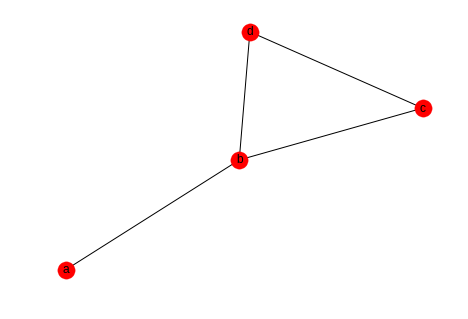

H['a']['b']:  {'key': [1], 'weight': 1}
H['b']['c']:  {'key': [2, 3], 'weight': 2}
H['b']['d']:  {'key': [3], 'weight': 1}


In [97]:
# minimum test example
H = build_graph({1:['a', 'b'], 2:['b', 'c'], 3:['b', 'c', 'd']}, attr_name='key')
print_graph(H, verbose=True, draw_graph=True)
print("H['a']['b']: ", H['a']['b'])
print("H['b']['c']: ", H['b']['c'])
print("H['b']['d']: ", H['b']['d'])

Below, a graph is built from the *graph_dict* dictionary. There are 9387 nodes, 5648732 edges (compared to 18270 nodes, 7409784 edges from *film_trope_dict*).

I decided not to store shared title info inside of this graph. Shared title lookup will have to be performed externally with a trope-to-titles dictionary.

In [17]:
# Build a graph from the graph_dict dictionary.

trope_graph = build_graph(graph_dict, attr_name=None)

In [18]:
print_graph(trope_graph)

Total Nodes: 9387
Total Edges: 5648732


In [20]:
## Pickling / Unpickling the graph 
## Unfortunately, this takes about the same amount of time as building the graph
## The pickled file ~ 170MB, definitely not going to be loaded as part of the future web app

## Save
# output = open('trope_graph.pkl', 'wb')
# pickle.dump(trope_graph, output, protocol=2) # default protocol is 3 in Python 3, not supported in Python 2
# output.close()

## Load
# pkl_file = open('trope_graph.pkl', 'rb')
# trope_graph = pickle.load(pkl_file)
# pkl_file.close()

In [22]:
degrees = trope_graph.degree(weight='weight')

In [23]:
degrees_df = pd.DataFrame.from_dict(degrees, orient='index').reset_index()
degrees_df.columns = ['trope', 'degree']

In [24]:
degrees_df.head()

,trope,degree
0,FrothyMugsOfWater,472
1,SecretlyDying,626
2,GlamorousSingleMother,173
3,HeroWithBadPublicity,3066
4,EldritchAbomination,5206


In [25]:
degrees_df['degree'].describe()

count      9387.000000
mean       2116.861404
std        4022.493563
min          80.000000
25%         572.500000
50%         994.000000
75%        2013.500000
max      106016.000000
Name: degree, dtype: float64

In [26]:
degrees_df['degree'].quantile([q/10.0 for q in xrange(1, 10)])

0.1     370.0
0.2     505.0
0.3     648.0
0.4     804.0
0.5     994.0
0.6    1280.0
0.7    1711.0
0.8    2458.6
0.9    4359.8
Name: degree, dtype: float64

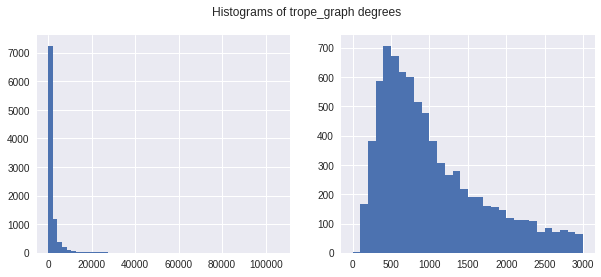

In [27]:
fig, axes = plt.subplots(ncols=2, figsize=(10, 4))
fig.suptitle('Histograms of trope_graph degrees', fontsize=12)
axes[0].hist(degrees_df['degree'], bins=50)
axes[1].hist(degrees_df['degree'], bins=30, range=(1, 3000))
plt.show()

In [28]:
# An example node from the graph
trope_graph['BookEnds']

{u'FrothyMugsOfWater': {'weight': 1},
 u'SecretlyDying': {'weight': 2},
 u'GlamorousSingleMother': {'weight': 1},
 u'EldritchAbomination': {'weight': 5},
 u'MeaningfulFuneral': {'weight': 5},
 u'ArcSymbol': {'weight': 4},
 u'RealLife': {'weight': 20},
 u'SarcasmBlind': {'weight': 1},
 u'MentalTimeTravel': {'weight': 3},
 u'HotPursuit': {'weight': 2},
 u'YoureNotMyFather': {'weight': 2},
 u'ProfessionalButtKisser': {'weight': 3},
 u'OffModel': {'weight': 2},
 u'AbsenteeActor': {'weight': 1},
 u'DarkerAndEdgier': {'weight': 45},
 u'CliffHanger': {'weight': 2},
 u'NoNewFashionsInTheFuture': {'weight': 5},
 u'MomentOfSilence': {'weight': 2},
 u'AbandonShip': {'weight': 3},
 u'CrustyCaretaker': {'weight': 1},
 u'SiblingTeam': {'weight': 7},
 u'BigBrotherIsEmployingYou': {'weight': 1},
 u'EnemyCivilWar': {'weight': 3},
 u'TrustMeImAnX': {'weight': 1},
 u'SlasherSmile': {'weight': 18},
 u'AmazinglyEmbarrassingParents': {'weight': 3},
 u'LondonEnglandSyndrome': {'weight': 4},
 u'StoutStrength'

In [29]:
# An example edge from the graph
trope_graph['BookEnds']['RealLife']

{'weight': 20}

Translate the graph to a nested dictionary.

In [33]:
def graph_to_dict(G):
    '''Translate the given graph to a nested dictionary, with the format of:
       {start_node_A: {neighbor_node1:weight1, neighbor_node2:weight2, ...}, 
        start_node_B: {...}
        ...
        }'''
    
    node_assn_dict = collections.defaultdict(dict)

    for start_node in G.nodes():
        for neighbor_node in G.neighbors(start_node):
            node_assn_dict[start_node][neighbor_node] = G[start_node][neighbor_node]['weight']
            
    return node_assn_dict

In [34]:
graph_to_dict(H)

defaultdict(dict,
            {'a': {'b': 1},
             'b': {'a': 1, 'c': 2, 'd': 1},
             'c': {'b': 2, 'd': 1},
             'd': {'b': 1, 'c': 1}})

In [35]:
trope_assn_dict = graph_to_dict(trope_graph)

In [36]:
len(trope_assn_dict)

9387

This pickled dictionary is still ~ 90 MB, probably should put that in a database instead.

In [2]:
## Pickling trope_assn_dict

## Save
# output = open('trope_assn_dict.pkl', 'wb')
# pickle.dump(trope_assn_dict, output, protocol=2) # default protocol is 3 in Python 3, not supported in Python 2
# output.close()

## Load
# pkl_file = open('trope_assn_dict.pkl', 'rb')
# trope_assn_dict = pickle.load(pkl_file)
# pkl_file.close()

Now write a series of helper functions that will be used to build the recommendation engine.

In [206]:
def add_space(text):
    '''Add spaces between captalized words, for better display of trope and movie names in the output.
       Spaces should be added just before the strings need to be outputted.'''
    return re.sub(r"\B([A-Z]+)", r" \1", text)

def strip_startcase(text):
    '''Strip spaces, capitalization, punctuation and accents from a string (movie titles or trope names).
       Weird unicode characters will be converted to ascii, eg. 'Nausicaä' to 'Nausicaa'.
       Then the text will be converted into a string of concatenated captalized words w/o spaces,
       eg.: 'BookEnds', 'YoureNotMyFather', 'RightForTheWrongReasons'. '''
    text = unidecode.unidecode(text) # dependency: unidecode
    text = re.sub(r'[^\w ]', '', text)
    return ''.join(w.title() for w in text.split())


def split_csv_str(text):
    '''Take a string of comma separated values, return a list of values with leading/trailing spaces removed.'''
    return [s.strip() for s in text.split(',')]


def join_two_dicts(dict1, dict2):
    '''Take 2 dictionaries, return a new dictionary, keeping only shared keys.
       All input/output dictionaries have the same format: {str1: int1, str2: int2, ...}.
       Each key will have a new value equals to the sum of all its old values among input dictionaries.'''    
    result_dict = {key : (dict1[key] + dict2[key]) for key in dict2.keys() if key in dict1}
    return result_dict

    
def join_n_dicts(dict_list):
    '''Take n (n>=2) dictionaries, return a new dictionary, keeping only shared keys.
       All input/output dictionaries have the same format: {str1: int1, str2: int2, ...}.
       Each key will have a new value equals to the sum of all its old values among input dictionaries.'''
    if len(dict_list) <= 1:
        return dict_list
    else:
        # reduce() will become functools.reduce() in Python 3
        return reduce(lambda x, y: join_two_dicts(x, y), dict_list)


def heapsort_nlargest(my_dict, n):
    '''Use heaps to efficiently find n largest items (sorted by value) from a dictionary.
       Return [(count_1st, item_1st), (count_2nd, item_2nd), ...]'''
    h = []
    for key, value in my_dict.items():
        heapq.heappush(h, (value, key))
    return heapq.nlargest(n, h)


In [228]:
# test
dict1={'a':10, 'c':20, 'd':30, 'e': 40, 'z': 1}
dict2={'a':2, 'b':2, 'd':3, 'e':4, 'z': 1}
dict3={'a':10, 'c':20, 'd':30, 'z': 1}
joined_dict = join_n_dicts([dict1, dict2, dict3])

print('joined dict 1-3: ', joined_dict)
print('sort large to small: ', heapsort_nlargest(joined_dict, len(joined_dict)))

joined dict 1-3:  {'a': 22, 'z': 3, 'd': 63}
sort large to small:  [(63, 'd'), (22, 'a'), (3, 'z')]


In [282]:
# TODO: find the most approperiate STAPLE_TROPES. Use top 10 for now.
STAPLE_TROPES = [u'ShoutOut', u'ChekhovsGun', u'DeadpanSnarker', u'OhCrap', u'Foreshadowing',
                 u'Jerkass', u'BittersweetEnding', u'LargeHam', u'TitleDrop', u'MeaningfulName']

class TropeRecommender(object):
    
    def __init__(self, input_string, assn_dict=trope_assn_dict, staple_tropes=STAPLE_TROPES):
        # master dictionary of trope associations
        self.assn_dict = assn_dict
        self.staple_tropes = staple_tropes
        
        # user_input should be a string of comma separated tropes
        if not isinstance(input_string, basestring):
            raise TypeError('User input should be a string')

        self.usr_tropes = split_csv_str(input_string)
        self.format_tropes()
        self.validate_tropes()

        self.combine_neighbors()
        self.filter_staples()
        
    def get_usr_tropes(self):    
        return self.usr_tropes
    
    def get_common_count_dict(self):
        return self.common_count_dict
    
    def get_staple_count_dict(self):
        return self.staple_count_dict
    
    def get_sorted_staple_counts(self):
        return [(t, n) for (n, t) in heapsort_nlargest(self.staple_count_dict, len(self.staple_count_dict))]
    
    def get_non_staple_count_dict(self):
        return self.non_staple_count_dict
    
    def format_tropes(self):
        self.usr_tropes = [strip_startcase(t) for t in self.usr_tropes]
    
    def validate_tropes(self): 
        # TODO: if switching to database queries, need to be changed to 'if key in list_of_legit_keys' 
        self.usr_tropes = [t for t in self.usr_tropes if t in self.assn_dict]
        
    def combine_neighbors(self):
        # calculate a count dict {trope: weight_sum} for neighbor tropes that are shared by all of self.usr_tropes
        dict_list = [self.assn_dict[t] for t in self.usr_tropes]
        self.common_count_dict = join_n_dicts(dict_list)
        
    def filter_staples(self, staple_list=None):
        if staple_list == None:
            staple_list = self.staple_tropes
            
        self.staple_count_dict = {}
        self.non_staple_count_dict = self.common_count_dict.copy()        
        for key in staple_list:
            value = self.non_staple_count_dict.pop(key, None)
            if value:
                self.staple_count_dict[key] = value

    def find_top_n(self, n=5, filter_out_staples=True):
        if filter_out_staples:
            dict_for_sorting = self.non_staple_count_dict
        else:
            dict_for_sorting = self.common_count_dict
            
        if n > len(dict_for_sorting):
            return None
        else:
            return [(key, value) for (value, key) in heapsort_nlargest(dict_for_sorting, n)]  
        
    def print_recommendations(self, n=5, filter_out_staples=True):
        print('-' * 35)
        print('User Tropes in Database: ')
        print('-' * 35)
        print(', '.join(add_space(i) for i in self.get_usr_tropes()), end='\n\n')

        print('-' * 35)
        print('No. of Shared Trope Associations: ')
        print('-' * 35)
        print(len(self.get_common_count_dict()), end='\n\n')
        
        print('-' * 35)
        print('Recommended New Tropes:')
        print('-' * 35)
        print('{:<50}{:<}'.format('Trope Name', 'No. of Movies with Co-Appearance'))
        for (trope, count) in self.find_top_n(n, filter_out_staples):
            print('{:<50}{:<}'.format(trope, count))
        print()
        
        print('-' * 35)
        print('Associated High Frequency Tropes:')
        print('-' * 35)
        print('{:<50}{:<}'.format('Trope Name', 'No. of Movies with Co-Appearance'))
        for (trope, count) in self.get_sorted_staple_counts()[:n]:
            print('{:<50}{:<}'.format(trope, count))
              
    

Testing the TropeRecommender class:

In [277]:
test_input1 = "not a trope, Book \n Ends, Girl Next Door, You're Not My Father, secretly dying, Time Travel Romance"
test_input2 = "Girl' Next Door, You're Not My Father, also not a trope"

In [288]:
#test1 = TropeRecommender(input_string=test_input1)
test2 = TropeRecommender(input_string=test_input2)

In [286]:
test1.print_recommendations()

-----------------------------------
User Tropes in Database: 
-----------------------------------
Book Ends, Girl Next Door, Youre Not My Father, Secretly Dying, Time Travel Romance

-----------------------------------
No. of Shared Trope Associations: 
-----------------------------------
34

-----------------------------------
Recommended New Tropes:
-----------------------------------
Trope Name                                        No. of Movies with Co-Appearance
BrickJoke                                         106
PrecisionFStrike                                  86
MoodWhiplash                                      84
WhatHappenedToTheMouse                            83
TheCameo                                          83

-----------------------------------
Associated High Frequency Tropes:
-----------------------------------
Trope Name                                        No. of Movies with Co-Appearance
ShoutOut                                          223
ChekhovsGun      

In [290]:
test2.print_recommendations()

-----------------------------------
User Tropes in Database: 
-----------------------------------
Girl Next Door, Youre Not My Father

-----------------------------------
No. of Shared Trope Associations: 
-----------------------------------
357

-----------------------------------
Recommended New Tropes:
-----------------------------------
Trope Name                                        No. of Movies with Co-Appearance
JerkWithAHeartOfGold                              9
TheCameo                                          8
NoodleIncident                                    8
HeroicSacrifice                                   8
WhatHappenedToTheMouse                            7

-----------------------------------
Associated High Frequency Tropes:
-----------------------------------
Trope Name                                        No. of Movies with Co-Appearance
ShoutOut                                          19
ChekhovsGun                                       12
Foreshadowing     

## For Capstone Video Demo

Sample user trope lists: